## Styling, Links and Modules
#### [`R interface to Keras`](https://tensorflow.rstudio.com/keras/) & [`Package "keras"`](https://cran.r-project.org/web/packages/keras/keras.pdf)

#### [`Deep Learning with R. François Chollet, J.J. Allaire`](https://github.com/jjallaire/deep-learning-with-r-notebooks)

#### [Full Version. Python](https://olgabelitskaya.github.io/kaggle_digits.html) & [Full Version. R](https://olgabelitskaya.github.io/kaggle_digits_R.html)

In [1]:
library(IRdisplay); library(repr)
library(tensorflow); library(keras)
library(imager); library(R6)

Loading required package: magrittr

Attaching package: ‘imager’

The following object is masked from ‘package:magrittr’:

    add

The following object is masked from ‘package:IRdisplay’:

    display

The following objects are masked from ‘package:stats’:

    convolve, spectrum

The following object is masked from ‘package:graphics’:

    frame

The following object is masked from ‘package:base’:

    save.image



In [2]:
display_html("<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color:#37c9e1; font-family:'Roboto';} 
h2 {color:slategray; font-family:'Orbitron'; text-shadow:4px 4px 4px #ccc;}
h4 {color:#818286; font-family:'Roboto';}
span {color:black; text-shadow:4px 4px 4px #ccc;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#37c9e1;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;} 
</style>")

## Data

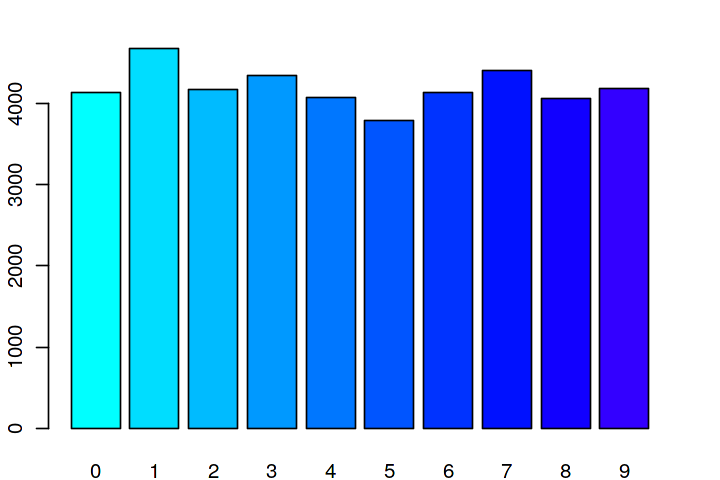

In [3]:
df_train<-read.csv("../input/train.csv")
df_test<-read.csv("../input/test.csv")
options(repr.plot.width=6,repr.plot.height=4)
par(mar=c(2,2,2,2))
df_train[,1] %>% 
  table() %>% 
  barplot(col=rainbow(10,start=.5,end=.7))

In [4]:
n<-nrow(df_train)
df_train<-df_train[sample(n),]

In [5]:
train_labels<-keras::to_categorical(as.matrix(df_train[,1]),
                                    num_classes=10)
train_images<-as.matrix(df_train[,-1])/255
test_images<-as.matrix(df_test)/255
dim(train_images); dim(test_images); dim(train_labels)

[1] 42000   784

[1] 28000   784

[1] 42000    10

In [6]:
train_images[15:20,15:20]

,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19
10436,0,0,0,0,0,0
14228,0,0,0,0,0,0
21089,0,0,0,0,0,0
17624,0,0,0,0,0,0
7387,0,0,0,0,0,0
35921,0,0,0,0,0,0


[1] 28 28

[1] 0 0 0 0 0 0 0 0 0 1

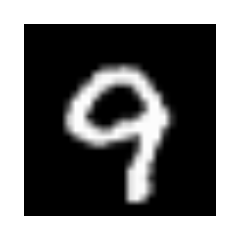

In [7]:
options(repr.plot.width=2,repr.plot.height=2)
par(mar=c(1,1,1,1))
image_example<-train_images[1000,]
image_example<-array_reshape(image_example,c(28,28))
dim(image_example); train_labels[1000,]
plot(as.raster(image_example))

In [8]:
train_indices<-1:round(.7*n)
valid_indices<-(round(.7*n)+1):round(.85*n)
test_indices<-(round(.85*n)+1):n
x_train<-train_images[train_indices,]
y_train<-train_labels[train_indices,]
x_valid<-train_images[valid_indices,]
y_valid<-train_labels[valid_indices,]
x_test<-train_images[test_indices,]
y_test<-train_labels[test_indices,]
dim(x_train); dim(x_valid); dim(x_test)
dim(y_train); dim(y_valid); dim(y_test)

[1] 29400   784

[1] 6300  784

[1] 6300  784

[1] 29400    10

[1] 6300   10

[1] 6300   10

## Neural Network Models

In [9]:
# CNN
cnn_model<-keras_model_sequential()
cnn_model %>% 
  layer_conv_2d(input_shape=c(28,28,1),
                filter=28,kernel_size=c(5,5),
                padding="same") %>%  
  layer_activation_leaky_relu(alpha=.02) %>%   
  layer_max_pooling_2d(pool_size=c(2,2)) %>%  
  layer_dropout(.25) %>%
  layer_conv_2d(filter=196,kernel_size=c(5,5),
                padding="same") %>% 
  layer_activation_leaky_relu(alpha=.02) %>%  
  layer_max_pooling_2d(strides=c(2,2)) %>%  
  layer_dropout(.25) %>%
  layer_global_max_pooling_2d() %>%  
  layer_dense(512) %>%  
  layer_activation_leaky_relu(alpha=.02) %>% 
  layer_dropout(.25) %>%    
  layer_dense(10) %>%    
  layer_activation("softmax")
cnn_model %>%
  compile(loss="categorical_crossentropy",
          optimizer="nadam",metrics="accuracy")
summary(cnn_model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 28, 28, 28)              728         
________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)           (None, 28, 28, 28)              0           
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 14, 14, 28)              0           
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 14, 14, 28)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 14, 14, 196)             137396      
________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)   

In [10]:
d<-c(dim(x_train)[1],28,28,1)
dv<-c(dim(x_valid)[1],28,28,1)
cnn_fit<-cnn_model %>%
  fit(x=array_reshape(x_train,d),y=y_train,
    validation_data=list(array_reshape(x_valid,dv),y_valid),
    shuffle=T,batch_size=128,epochs=50,
    callbacks=list(callback_model_checkpoint("cnn_best_digits.h5",
                                             save_best_only=T),
                   callback_reduce_lr_on_plateau(monitor="val_loss",
                                                 factor=.5)))

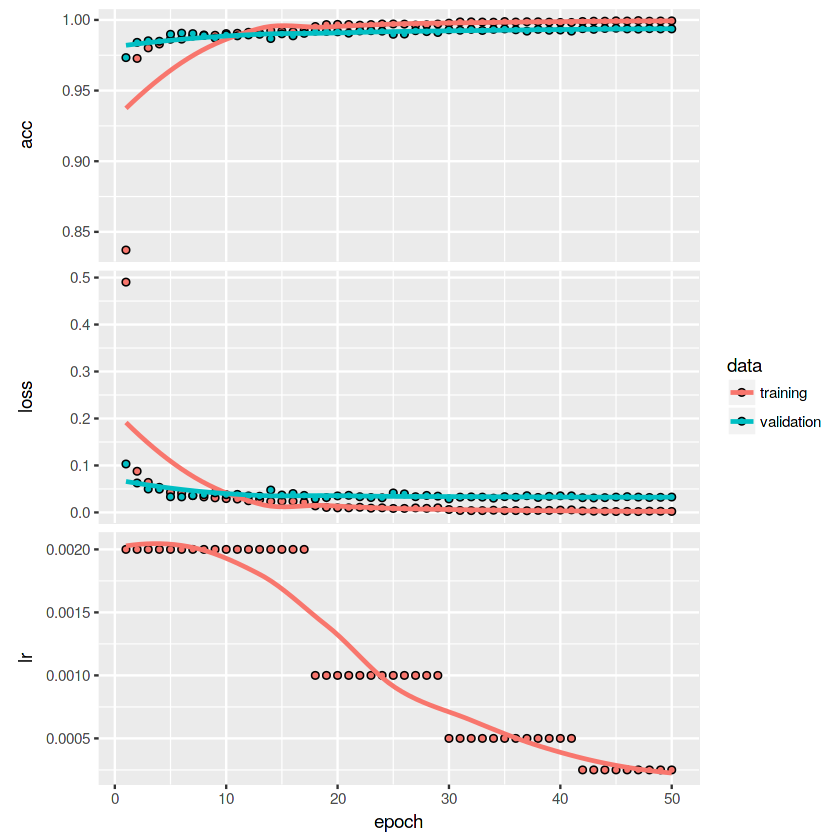

In [11]:
options(warn=-1,repr.plot.width=7,repr.plot.height=7)
plot(cnn_fit)

In [12]:
cnn_fit_df<-as.data.frame(cnn_fit)
cnn_fit_df[81:100,]

,epoch,value,metric,data
81,31,0.004167806,loss,training
82,32,0.003845598,loss,training
83,33,0.003914615,loss,training
84,34,0.004696730,loss,training
85,35,0.003768367,loss,training
86,36,0.003946478,loss,training
87,37,0.003593650,loss,training
88,38,0.004347238,loss,training
89,39,0.004391962,loss,training
90,40,0.004954607,loss,training


In [13]:
dt<-c(dim(x_test)[1],28,28,1)
load_model_weights_hdf5(cnn_model,"cnn_best_digits.h5")
cnn_score<-cnn_model %>% 
  evaluate(array_reshape(x_test,dt),y_test)
cnn_score

$loss
[1] 0.03525561

$acc
[1] 0.991746

In [14]:
generated_images<-image_data_generator(
  shear_range=.3,zoom_range=.3,rotation_range=30,
  width_shift_range=.3,height_shift_range=.3)
generated_images %>% 
    fit_image_data_generator(array_reshape(x_train,d))

In [15]:
dg_cnn_fit<-cnn_model %>%
  fit_generator(flow_images_from_data(array_reshape(x_train,d),
                                      y_train,generated_images,
                                      batch_size=128), 
                steps_per_epoch=1000,epochs=50,
                validation_data=list(array_reshape(x_valid,dv),y_valid),
                callbacks=list(callback_model_checkpoint("cnn_best_digits.h5",
                                                         save_best_only=T),
                               callback_reduce_lr_on_plateau(monitor="val_loss",
                                                             factor=.5)))

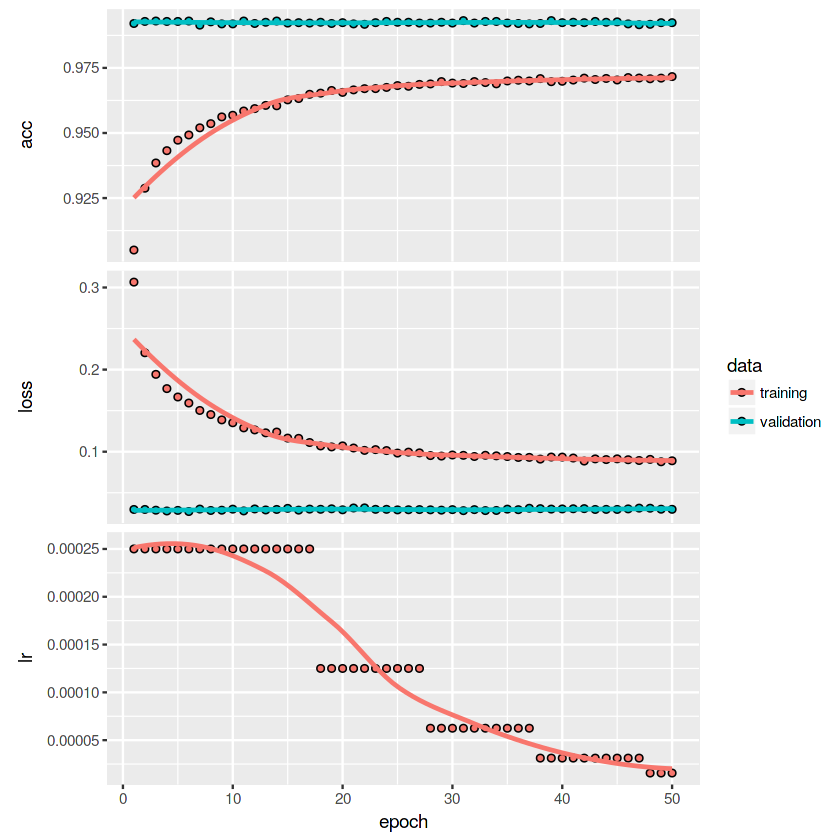

In [16]:
options(warn=-1,repr.plot.width=7,repr.plot.height=7)
plot(dg_cnn_fit)

In [17]:
load_model_weights_hdf5(cnn_model,"cnn_best_digits.h5")
cnn_score<-cnn_model %>% 
  evaluate(array_reshape(x_test,dt),y_test)
cnn_score

$loss
[1] 0.02614389

$acc
[1] 0.9928571

In [18]:
cnn_predict<-cnn_model %>% 
  predict_classes(array_reshape(test_images,
                                c(dim(test_images)[1],28,28,1)),
                  batch_size=128)
submission<-data.frame(ImageId=1:dim(test_images)[1],
                       Label=cnn_predict)
write.csv(submission,row.names=F,
          file="R_submission_digits.csv")

In [19]:
real_test_labels<-c(2, 0, 9, 0, 3, 7, 0, 3, 0, 3,
                    5, 7, 4, 0, 4, 3, 3, 1, 9, 0,
                    9, 1, 1, 5, 7, 4, 2, 7, 4, 7,
                    7, 5, 4, 2, 6, 2, 5, 5, 1, 6,
                    7, 7, 4, 9, 8, 7, 8, 2, 6, 7,
                    6, 8, 8, 3, 8, 2, 1, 2, 2, 0,
                    4, 1, 7, 0, 0, 0, 1, 9, 0, 1,
                    6, 5, 8, 8, 2, 8, 9, 9, 2, 3,
                    5, 4, 1, 0, 9, 2, 4, 3, 6, 7,
                    2, 0, 6, 6, 1, 4, 3, 9, 7, 4,
                    0, 9, 2, 0, 7, 3, 0, 5, 0, 8,
                    0, 0, 4, 7, 1, 7, 1, 1, 3, 3,
                    3, 7, 2, 8, 6, 3, 8, 7, 7, 4,
                    3, 5, 4, 0, 0, 0, 3, 1, 3, 6,
                    4, 3, 4, 5, 5, 8, 7, 4, 2, 8,
                    4, 3, 5, 6, 5, 3, 7, 5, 7, 8,
                    3, 0, 4, 5, 1, 3, 7, 6, 3, 0,
                    2, 7, 8, 6, 1, 3, 7, 4, 1, 2,
                    4, 8, 5, 2, 4, 9, 2, 1, 6, 0,
                    6, 1, 4, 9, 6, 0, 9, 7, 6, 9,
                    1, 9, 0, 9, 9, 0, 8, 4, 6, 2,
                    0, 9, 3, 6, 3, 2, 1, 6, 3, 4,
                    2, 3, 1, 2, 2, 0, 4, 6, 1, 0,
                    0, 4, 9, 1, 7, 3, 2, 3, 8, 6,
                    8, 6, 2, 8, 5, 5, 4, 8, 3, 5,
                    9, 7, 1, 3, 8, 4, 5, 1, 4, 5,
                    6, 3, 3, 5, 7, 0, 6, 8, 3, 1,
                    6, 0, 6, 3, 9, 5, 1, 5, 8, 4,
                    0, 9, 2, 0, 5, 3, 7, 1, 9, 9,
                    5, 7, 7, 9, 9, 6, 3, 0, 3, 3)

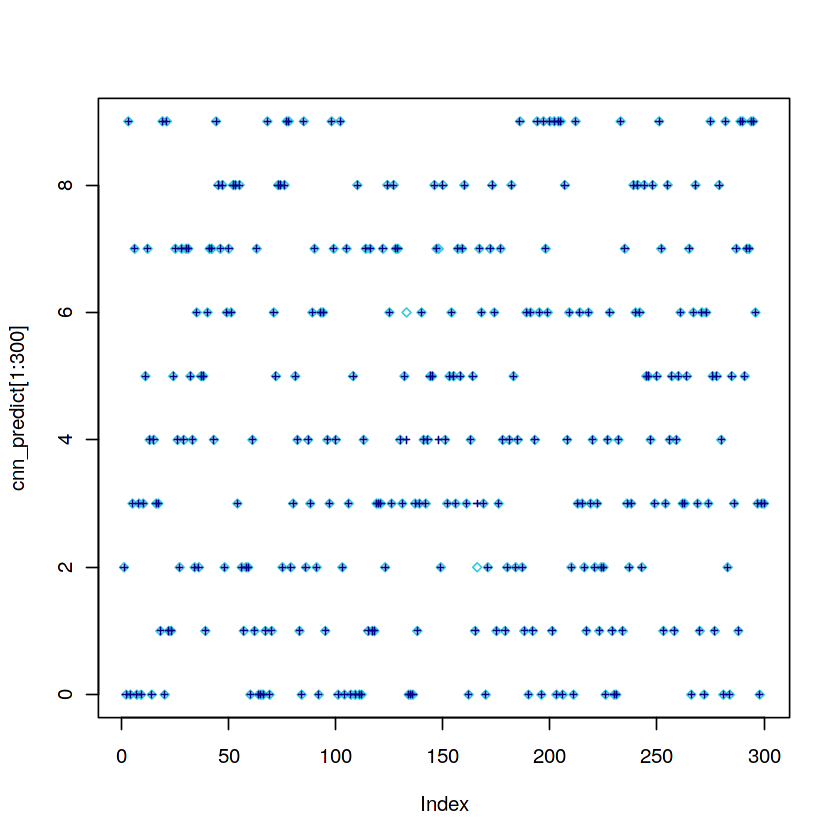

In [20]:
plot(cnn_predict[1:300],pch=5,cex=.7,col='#37c9e1')
points(real_test_labels,pch=3,cex=.5,col='darkblue')